# Variational Quantum Eigensolver - Ground State Energy for $LiH$ Molecule using the RY ansatz

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-18 20:40:28,578: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [3]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for LIH molecule at equilibrium bond length 1.5474 Angstrom

In [4]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [5]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [6]:
def initial_state_preparation(dist: float, mapper_str: str = "jw"):
    
    molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)#1.5474"
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [7]:
inter_atomic_dists: list = np.arange(1.10, 1.90, 0.05)

In [8]:
numpy_minimum_solver_electronic_ground_energies: list = []
numpy_solver_nuclear_repulsion_energies: list = []
numpy_minimum_solver_total_ground_state_energies: list = []

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_solver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_minimum_solver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_minimum_solver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))



Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 1.1000 Å 	 Electronic Ground Energy: -9.2687 Eh 	Total Ground State Energy: -7.8255 Eh
Interatomic dist: 1.1500 Å 	 Electronic Ground Energy: -9.2209 Eh 	Total Ground State Energy: -7.8405 Eh
Interatomic dist: 1.2000 Å 	 Electronic Ground Energy: -9.1754 Eh 	Total Ground State Energy: -7.8524 Eh
Interatomic dist: 1.2500 Å 	 Electronic Ground Energy: -9.1319 Eh 	Total Ground State Energy: -7.8619 Eh
Interatomic dist: 1.3000 Å 	 Electronic Ground Energy: -9.0903 Eh 	Total Ground State Energy: -7.8691 Eh
Interatomic dist: 1.3500 Å 	 Electronic Ground Energy: -9.0505 Eh 	Total Ground State Energy: -7.8746 Eh
Interatomic dist: 1.4000 Å 	 Electronic Ground Energy: -9.0124 Eh 	Total Ground State Energy: -7.8785 Eh
Interatomic dist: 1.4500 Å 	 Electronic Ground Energy: -8.9758 Eh 	Total Ground State Energy: -7.8810 Eh
Interatomic dist: 1.5000 Å 	 Electronic Ground Energy: -8.9407 Eh 	Total Gro

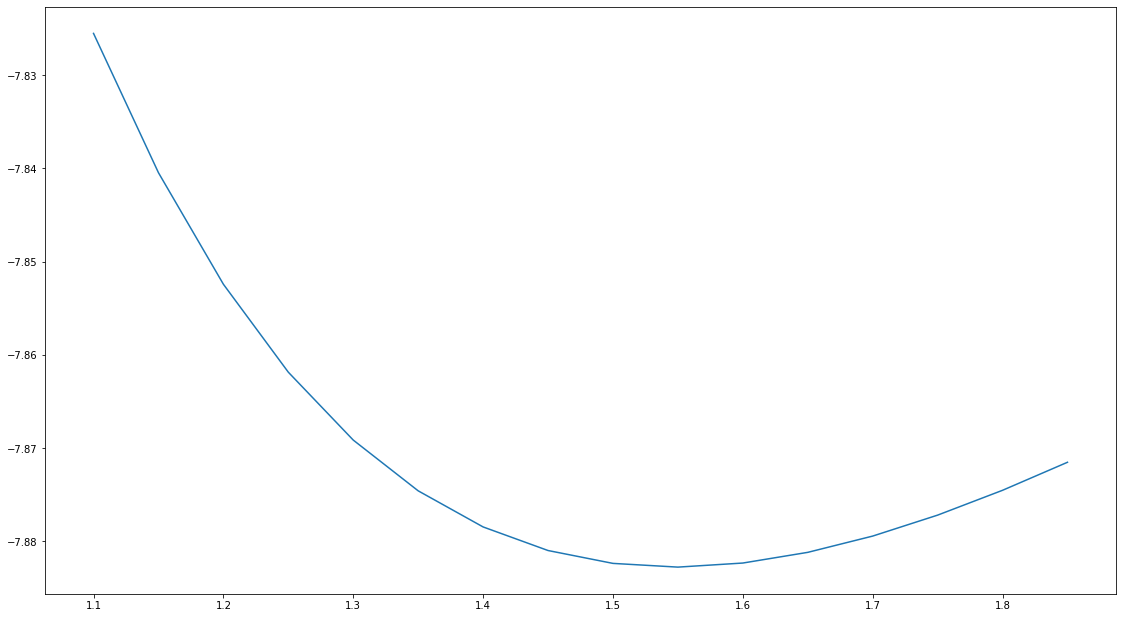

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.show()

In [17]:
uccsd_solver_electronic_ground_energies: list = []
uccsd_solver_nuclear_repulsion_energies: list = []
uccsd_solver_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_toronto')
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)
optimizer = SLSQP(maxiter=5)
# optimizer = COBYLA(maxiter=10000)

print("Total Ground State Energies of H2 Molecule using UCCSD ansatz\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "RY"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        insert_barriers=True)

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=state_sim,
        callback=callback,
        initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    uccsd_solver_total_ground_state_energies.append( np.real(result.eigenvalue) )
    print("\n\n", np.real(result.eigenvalue))

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 91,
    'eigenstate': array([ 9.78700407e-02-4.11409588e-18j, -2.38361095e-01+1.00139455e-17j,
        1.98829320e-01-5.99554046e-18j, -4.78177100e-01+1.44219439e-17j,
        5.45981499e-03-5.76143093e-18j, -1.31892469e-02+1.40232009e-17j,
       -3.23479843e-02-8.21427461e-18j,  7.77425078e-02+1.97592978e-17j,
        6.78038516e-02-2.83207482e-18j, -1.65138005e-01+6.89298971e-18j,
        1.38827977e-01-3.94915944e-18j, -3.33874785e-01+9.49979046e-18j,
        1.25351188e-03-4.38303206e-18j, -2.97994317e-03+1.06685236e-17j,
       -2.67874742e-02-6.37619855e-18j,  6.43869596e-02+1.53376153e-17j,
        1.65795522e-02-7.14024917e-19j, -4.03767355e-02+1.73839451e-18j,
        3.26659014e-02-1.20815594e-18j, -7.85615192e-02+2.90586681e-18j,
        3.30516486e-03-6.07497347e-19j, -8.02959581e-03+1.47833799e-18j,
       -1.36038121e-03-7.46454483e-19j,  3.26177896e-03+1.79579235e-18j,
        3.16324389e-03-1.07468275e-19

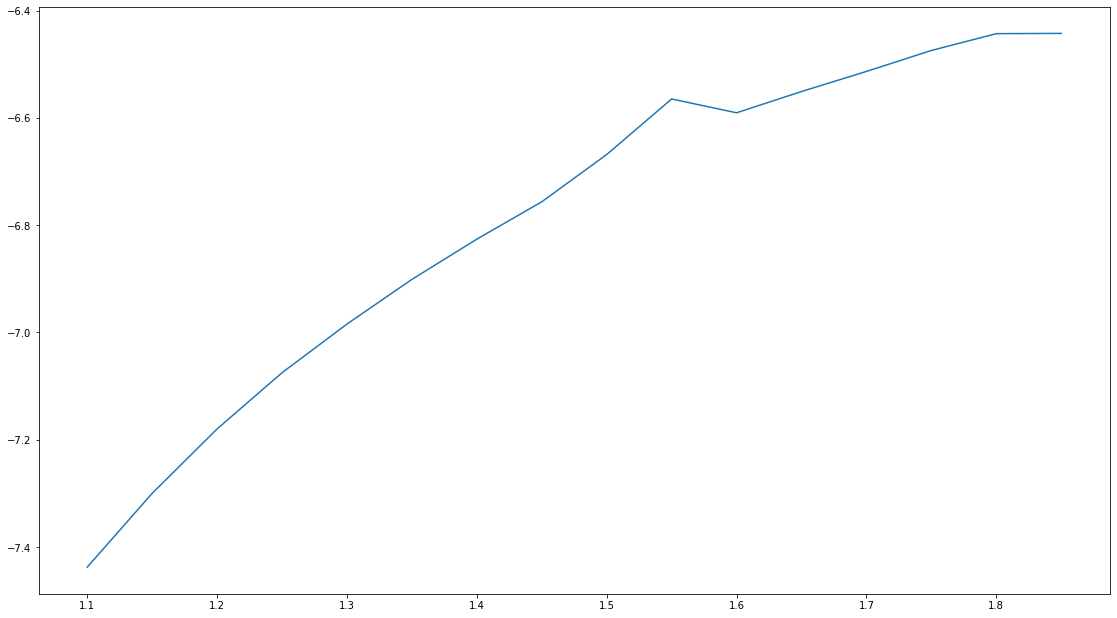

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(inter_atomic_dists, uccsd_solver_total_ground_state_energies)
plt.show()

## Solver

### Exact Eigensolver using NumPyMinimumEigensolver

### VQE Solver